# Exoplanet Hunt

*In this notebook one will study different approaches to the given problem. Multiple models, as well as different variations of processed data will be tested.*

## Settings

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import time
from scipy import signal

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, Input
from tensorflow.keras.layers import LSTM, Embedding

from tensorflow.keras import models
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [2]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='00d1169e-7a6b-4dd3-a1d5-f964c526647d', project_access_token='p-62e5553d194b5733a0f8412ab66d3e456d2f736e')
pc = project.project_context


## Local or Colab

In [3]:
# from google.colab import drive
# drive.mount('/gdrive')

In [4]:
# %cd "/gdrive/My Drive/IBM DS Capstone"

In [5]:
# %ls

# Model definition

Each model is defined in a separate function, that takes input_shape as an input. All other parameters, such as number of neurons in the layer are kept constant for the sake of purity of comparison between models.

## `Model naming`

Every NN model is named as a combination of letters 'm' + one of the following:

* `d - dense network, or MLP`
* `c - convolutional network`
* `l - LSTM based network`

Then, a tag for the kind of data that it was trained on is added:

* `_clean - clean normalized data`
* `_trend - detrended normalized data`
* `_freq - normalized half spectrums obtained from detrended data`
* `_wave - wavelet transformed 2D data`

Thus, a convolutional network trained on frequency spectrum data will be named `mc_freq`, for example.

A support vector classifier model is considered as well in each experiment under the name of `svc`.


## Evaluation

To compare models and evaluate their performance one needs to define a set of measures that will serve this purpose. 

Having in mind the objective of a problem - binary classification - we suggest next indicators could be used as evaluating measurements of the models:

1. `Loss - Binary CrossEntropy`
2. `Accuracy`
3. `Sensitivity & Specificity`
4. `Precision & Recall`
5. `F1-score`


In [6]:
def evaluate_prediction(y_true, y_pred, certainty=0.5):

    y_pred = y_pred.flatten('F')
    y_pred = np.array([1 if p >= certainty else 0 for p in y_pred])
    # calculating all the measures
    TP = len([p for i, p in enumerate(y_true) if y_pred[i] and p])
    TN = len([p for i, p in enumerate(y_pred) if not y_true[i] and not p])
    FP = len([p for i, p in enumerate(y_pred) if not y_true[i] and p])
    FN = len([p for i, p in enumerate(y_true) if not y_pred[i] and p])

    # evaluation
    Sensitivity = 0
    if (TP + FN):
        Sensitivity = TP/(TP + FN)

    Specificity = 0    
    if (TN + FP):
        Specificity = TN/(TN + FP)
    
    Precision = 0
    if (TP + FP):
        Precision = TP/(TP + FP)
        
    Recall = 0
    if (TN + FN):
        Recall = TN/(TN + FN)
    
    F1 = None
    if (Precision + Recall):
        F1 = 2*Precision*Recall/(Precision + Recall)

    score = pd.DataFrame([[Sensitivity, Specificity, Precision, Recall, F1]], 
                        columns=['Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1-score'])
    
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                    columns=['Predicted No planets', 'Predicted Planets'],
                    index=['True no planets', 'True Planets'])

    fig, ax = plt.subplots(figsize=(8, 8))
    hm = sns.heatmap(np.round(cm, 3), annot=True, ax=ax, 
                    cmap='magma', fmt='.3f')
    fig.suptitle('Confusion matrix', fontsize=18)
    
    return score

## Model definition functions

In [7]:
def Dense_Net(input_shape, summary=False):

    # input
    Input_Layer = Input(shape=input_shape)

    # hidden layers
    Hidden_Layer1 = Dense(200, activation='relu')(Input_Layer)
    Hidden_Layer2_dropout = Dropout(0.4)(Hidden_Layer1)

    Hidden_Layer2 = Dense(50, activation='relu')(Hidden_Layer2_dropout)
    Hidden_Layer2_dropout = Dropout(0.3)(Hidden_Layer2)

    Hidden_Layer3 = Dense(20, activation='relu')(Hidden_Layer2_dropout)
    Hidden_Layer3_dropout = Dropout(0.3)(Hidden_Layer3)

    Output_Layer = Dense(1, activation='sigmoid')(Hidden_Layer3_dropout)

    model = Model(inputs=Input_Layer, outputs=Output_Layer)

    # summarize layers
    if summary:
        print(model.summary())  
    
    return model

In [8]:
def LSTM_Net(input_shape, summary=False):

    # input
    Input_Layer = Input(shape=input_shape)

    # hidden layers
    Y = tf.keras.layers.LSTM(100,
                        stateful=False,
                        recurrent_initializer='glorot_uniform',
                        return_sequences=True)(Input_Layer)
    Y = tf.keras.layers.LSTM(50,
                        stateful=False,
                        recurrent_initializer='glorot_uniform')(Y)
    
    Y = Dense(42, activation='relu')(Y)

    Output_Layer = Dense(1, activation='sigmoid')(Y)

    model = tf.keras.Model(inputs=Input_Layer,
                    outputs = Output_Layer)
    
    # summarize layers
    if summary:
        print(model.summary())  

    return model

In [9]:
def CNN2D(input_shape, summary=False):
    # input
    Input_Layer = Input(shape=input_shape, name='input')  

    # model
    # layer 1
    Y = Conv2D(16, 3, padding='same', activation='relu')(Input_Layer)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.25)(Y)

    # layer 2
    Y = Conv2D(32, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.33)(Y)

    # layer 3
    Y = Conv2D(64, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.5)(Y)

    # output
    Y = Flatten()(Y)
    Y = Dense(512, activation='relu')(Y)
    Output_Layer = Dense(1, activation='sigmoid')(Y)

    model = tf.keras.Model(inputs=Input_Layer,
                        outputs = Output_Layer)
    
    # summarize layers
    if summary:
        print(model.summary())  

    return model

In [10]:
def CNN1D(input_shape, summary=False):
    # input
    Input_Layer = Input(shape=input_shape, name='input')  

    # model
    # layer 1
    Y = Conv1D(8, 3, padding='same', activation='relu')(Input_Layer)
    Y = MaxPooling1D()(Y)
    Y = Dropout(0.25)(Y)

    # layer 2
    Y = Conv1D(16, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling1D()(Y)
    Y = Dropout(0.33)(Y)

    # layer 3
    Y = Conv1D(32, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling1D()(Y)
    Y = Dropout(0.5)(Y)

    # output
    Y = Flatten()(Y)
    Y = Dense(512, activation='relu')(Y)
    Output_Layer = Dense(1, activation='sigmoid')(Y)

    model = tf.keras.Model(inputs=Input_Layer,
                        outputs = Output_Layer)
    
    # summarize layers
    if summary:
        print(model.summary())  

    return model

## Trainer

*A class, which aim is to train and evaluate Keras-made models.*

In [11]:
class Trainer():

    def __init__(self, model, model_name, train_data_generator, valid_data_generator):

        # data
        self.train_data = train_data_generator
        self.valid_data = valid_data_generator

        # model
        self.model = model
        self.model_name = model_name + '.json'
        self.weights_name = model_name + '.h5'
        self.classes = 0

        # training info
        self.history = None
        self.Nb_epochs = 10
        self.durations = []
        self.total_duration = 0
        self.loss_history = []
        self.val_loss_history = []
        self.acc_history= []
        self.val_acc_history = []

        # early stopping
        self.best_epoch = 0
        self.patience = 0

        # evaluation info
        self.score = None

    def train(self, Nb_epochs, batch_size,
              patience=10, monitor="val_loss", mode='min'):

        self.Nb_epochs = Nb_epochs
        self.patience = patience
        # early stopping initialization
        counter = 0
        self.best_epoch = 0
        if mode == 'min':
            best_value = 1e10
        if mode == 'max':
            best_value = -3      

            # training epoch
        try:
            for i in range(Nb_epochs):
                if counter >= patience:
                    print("The model is not improving any more. Stopping the training process..")
                    print("The last model was saved on epoch {:d}, with ".format(self.best_epoch) + 
                            monitor + " value of {:.2f}".format(best_value))
                    break
                starting_time = time.time()
                
                # data generation
                X_ep, Y_ep = next(self.train_data)
                X_val_ep, Y_val_ep = next(self.valid_data)

                self.history = self.model.fit(
                    X_ep,
                    Y_ep,
                    batch_size=batch_size,
                    initial_epoch=i,
                    epochs=i+1,    
                    validation_data=(X_val_ep, Y_val_ep))

                # saving training epoch history
                self.duration=time.time()-starting_time
                self.durations.append(self.duration)
                self.total_duration+=self.duration

                self.loss_history.append(self.history.history["loss"][0])
                self.val_loss_history.append(self.history.history["val_loss"][0])
                self.acc_history.append(self.history.history["acc"][0])
                self.val_acc_history.append(self.history.history["val_acc"][0])


                target = self.history.history[monitor][0]
                if mode == 'min':
                    if target < best_value:
                        print(monitor + " improved from {:.2f} to {:.2f}".format(best_value, target))
                        best_value = target
                        self.best_epoch = i+1
                        self._save_model()
                        print("Model is saved on epoch {:d}.".format(self.best_epoch))
                        counter = 0
                    else:
                        print(monitor + " did not improve.")
                        counter += 1

                if mode == 'max':
                    if target > best_value:
                        print(monitor + " improved from {:.2f} to {:.2f}".format(best_value, target))
                        best_value = target
                        self.best_epoch = i+1
                        self._save_model()
                        print("Model is saved on epoch {:d}.".format(self.best_epoch))
                        counter = 0
                    else:
                        print(monitor + " did not improve.")
                        counter += 1

            self.load_model(model_name=self.model_name, weights_name=self.weights_name)

        except KeyboardInterrupt:
            print("\n Interrupted.")
          
     
    def plot_training(self):

        fig,ax = plt.subplots(2,1 , figsize=(16, 10), sharex=True)

        # loss
        a=np.arange(min(self.Nb_epochs, self.best_epoch+self.patience))
        ax[0].plot(a,self.loss_history,label="loss")
        ax[0].plot(a,self.val_loss_history,label="val_loss")
        ax[0].legend()
        ax[0].set_title("Loss per epoch", color='coral', fontsize=16)
        ax[0].tick_params(colors='coral')

        if len(a)<30:
            ax[0].set_xticks(a)
        else:
            ax[0].set_xticks(np.arange(0,self.Nb_epochs,50))
            ax[0].set_xticklabels(np.arange(0,self.Nb_epochs,50), rotation=75)

        ax[0].set_xlabel("epoch")
        fig.savefig("loss_per_epoch.png")

        # accuracy
        ax[1].plot(a,self.acc_history,label="acc")
        ax[1].plot(a,self.val_acc_history,label="val_acc")
        ax[1].legend()
        ax[1].set_title("Accuracy per epoch", color='coral', fontsize=16)
        ax[1].tick_params(colors='coral')

        if len(a)<30:
            ax[1].set_xticks(a)
        else:
            ax[1].set_xticks(np.arange(0,self.Nb_epochs,50))
            ax[1].set_xticklabels(np.arange(0,self.Nb_epochs,50), rotation=75)

        ax[1].set_xlabel("epoch")
        fig.savefig("acc_per_epoch.png")
    
        return self.acc_history, self.val_acc_history, self.loss_history, self.val_loss_history
  
    def evaluate_model(self, test_data, y_true, certainty=0.5):

        loss, acc = self.model.evaluate(test_data)
        y_pred = self.model.predict(test_data)
        y_pred = y_pred.flatten('F')
        y_pred = np.array([1 if p >= certainty else 0 for p in y_pred])

        # Sensitivity
        TP = [p for i, p in enumerate(y_true) if y_pred[i] and p]

        if len(y_pred[y_pred == 1]):
            pos = len(y_pred[y_pred == 1])
            Sensitivity = len(TP)/pos
        else:
            Sensitivity = 0

        # Specificity
        TN = [p for i, p in enumerate(y_pred) if y_true[i] == 0 and not p]
        
        if len(y_pred[y_pred == 0]):
            neg = len(y_pred[y_pred == 0])
            Specificity = len(TN)/neg
        else:
            Specificity = 0

        score = pd.DataFrame([[loss, acc, Sensitivity, Specificity]], 
                            columns=['Loss', 'Accuracy', 'Sensitivity', 'Specificity'])
        
        cm = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize='all'), 
                        columns=['Predicted No planets', 'Predicted Planets'],
                        index=['True no planets', 'True Planets'])

        fig, ax = plt.subplots(figsize=(8, 8))
        hm = sns.heatmap(np.round(cm, 3), annot=True, ax=ax, 
                        cmap='magma', fmt='.3f')
        fig.suptitle('Confusion matrix', fontsize=18)
        
        return score

    def _save_model(self):
      
        # serialize model to JSON
        model_json = self.model.to_json()
        with open(self.model_name, "w") as json_file:
              json_file.write(model_json)

        # serialize weights to HDF5
        self.model.save_weights(self.weights_name)

    def load_model(self, replace=True, model_name="model.json", 
                 weights_name="model.h5"):
    
        # load json and create model
        json_file = open(model_name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = models.model_from_json(loaded_model_json)

        # load weights into new model
        loaded_model.load_weights(weights_name)
        print("Model is loaded from a disk")
        
        if replace:
            self.model = loaded_model
        
        return loaded_model

In [12]:
def get_label(x_train, y_train, label):

    only_true_x = np.array([row for i, row in enumerate(x_train) if y_train[i] == label])
    if label:   
        only_true_y = np.ones(only_true_x.shape[0], dtype='int32')
    else:
        only_true_y = np.zeros(only_true_x.shape[0], dtype='int32')

    return only_true_x, only_true_y

In [13]:
def train_generator(x_train, y_train, batch_size=100, ratio_of_minor=0.1,
                   mlp=False):
    

    data = np.concatenate([x_train, y_train], axis=1)

    ones = data[data[:, -1] == 1]
    a_ones = np.arange(len(ones))
    zeros = data[data[:, -1] == 0]
    a_zeros = np.arange(len(zeros))

    # loop of the generator; 
    while True:    
        ones_to_pick = np.random.choice(a_ones, size=int(batch_size*ratio_of_minor))
        batch_of_ones = ones[ones_to_pick]
        zeros_to_pick = np.random.choice(a_zeros, size=int(batch_size*(1-ratio_of_minor)))
        batch_of_zeros = zeros[zeros_to_pick]

        batch = np.concatenate([batch_of_ones, batch_of_zeros], axis=0)
        
        if mlp:
            yield batch[:, :-1], batch[:, -1]
        else:
            yield batch[:, :-1, np.newaxis], batch[:, -1]

In [14]:
def load_csv_Watson(filename):
    
    f = project.get_file(filename)
    x = pd.read_csv(f).to_numpy()
    return x

## Modeling on Clean Normalized Data

In [19]:
# x_train = np.load("data/clean_train.npy")
# x_test = np.load("data/clean_test.npy")
# y_train = np.load("data/label_train.npy").astype('int32')
# y_test = np.load("data/label_test.npy").astype('int32')

x_train = load_csv_Watson('clean_train.csv')
x_test = load_csv_Watson('clean_test.csv')

y_train = load_csv_Watson('labels_train.csv')
y_test = load_csv_Watson('labels_test.csv')

In [64]:
# custom train generators
train_gen = train_generator(x_train, y_train, ratio_of_minor=0.25, batch_size=100)
val_gen = train_generator(x_train, y_train, ratio_of_minor=0.25, batch_size=50)
train_gen_mlp = train_generator(x_train, y_train, ratio_of_minor=0.25, batch_size=100, mlp=True)
val_gen_mlp = train_generator(x_train, y_train, ratio_of_minor=0.25, batch_size=50, mlp=True)
a, b = next(train_gen)
a.shape, b.shape

((100, 3197, 1), (100,))

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [22]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 5

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [70]:
md_clean = Dense_Net((x_train.shape[1],))

In [66]:
ml_clean = LSTM_Net((x_train.shape[1], 1))

In [67]:
mc_clean = CNN1D((x_train.shape[1], 1))

In [71]:
md_clean.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
md_clean_trainer = Trainer(md_clean, 'md_clean', train_gen_mlp, val_gen_mlp)
md_clean_trainer.train(25, 100)

Train on 100 samples, validate on 49 samples
100/100 [==============================] - 4s 35ms/sample - loss: 0.7210 - acc: 0.3200 - val_loss: 0.6934 - val_acc: 0.6122
val_loss improved from 10000000000.00 to 0.69
Model is saved on epoch 1.
Train on 100 samples, validate on 49 samples
Epoch 2/2
100/100 [==============================] - 0s 447us/sample - loss: 0.6937 - acc: 0.5100 - val_loss: 0.6890 - val_acc: 0.6735
val_loss improved from 0.69 to 0.69
Model is saved on epoch 2.
Train on 100 samples, validate on 49 samples
Epoch 3/3
100/100 [==============================] - 0s 346us/sample - loss: 0.6839 - acc: 0.6500 - val_loss: 0.6723 - val_acc: 0.7551
val_loss improved from 0.69 to 0.67
Model is saved on epoch 3.
Train on 100 samples, validate on 49 samples
Epoch 4/4
100/100 [==============================] - 0s 347us/sample - loss: 0.6787 - acc: 0.6700 - val_loss: 0.6694 - val_acc: 0.7551
val_loss improved from 0.67 to 0.67
Model is saved on epoch 4.
Train on 100 samples, validat

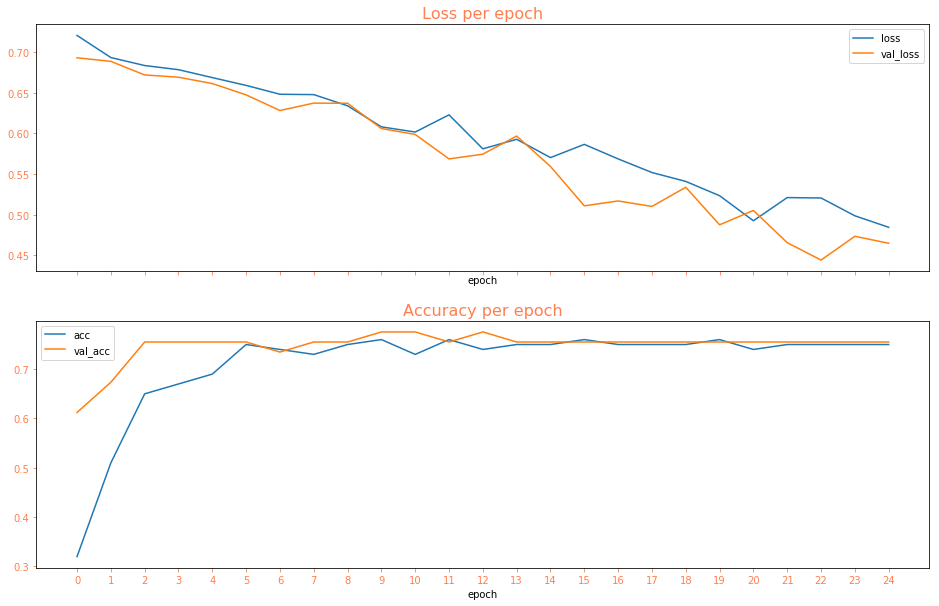

In [72]:
md_clean_trainer.plot_training();

In [56]:
ml_clean.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
ml_clean_trainer = Trainer(ml_clean, 'ml_clean', train_gen, val_gen)

In [57]:
ml_clean_trainer.train(2, 1)

Train on 100 samples, validate on 49 samples
  1/100 [..............................] - ETA: 1:28:43 - loss: 0.6931 - acc: 1.0000
 Interrupted.


In [73]:
mc_clean.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
mc_clean_trainer = Trainer(mc_clean, 'mc_clean', train_gen, val_gen)
mc_clean_trainer.train(25, 100)

Train on 100 samples, validate on 49 samples
100/100 [==============================] - 5s 46ms/sample - loss: 0.6881 - acc: 0.6200 - val_loss: 0.4738 - val_acc: 0.7551
val_loss improved from 10000000000.00 to 0.47
Model is saved on epoch 1.
Train on 100 samples, validate on 49 samples
Epoch 2/2
100/100 [==============================] - 1s 9ms/sample - loss: 0.5182 - acc: 0.7500 - val_loss: 0.4746 - val_acc: 0.7551
val_loss did not improve.
Train on 100 samples, validate on 49 samples
Epoch 3/3
100/100 [==============================] - 1s 9ms/sample - loss: 0.5762 - acc: 0.7500 - val_loss: 0.5437 - val_acc: 0.7551
val_loss did not improve.
Train on 100 samples, validate on 49 samples
Epoch 4/4
100/100 [==============================] - 1s 9ms/sample - loss: 0.5128 - acc: 0.7500 - val_loss: 0.5476 - val_acc: 0.7551
val_loss did not improve.
Train on 100 samples, validate on 49 samples
Epoch 5/5
100/100 [==============================] - 1s 8ms/sample - loss: 0.4628 - acc: 0.7500 - val

,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.0,1.0,0,0.991228,0.0


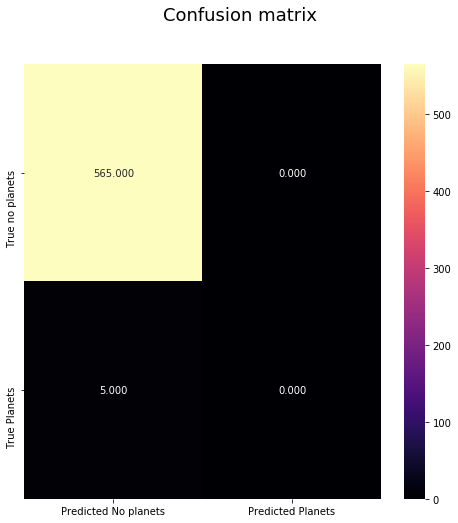

In [84]:
md_clean_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
md_clean = md_clean_trainer.model
y_pred = md_clean.predict(x_test)
evaluate_prediction(y_test, y_pred)

In [0]:
ml_clean_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
ml_clean = ml_clean_trainer.model
y_pred = ml_clean.predict(x_test)
evaluate_prediction(y_test, y_pred)

,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.0,1.0,0,0.991228,0.0


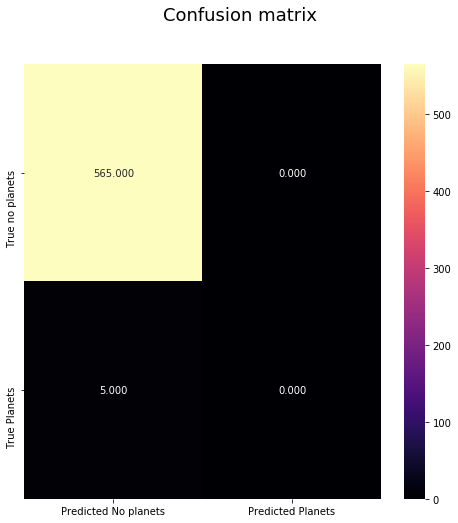

In [86]:
mc_clean_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
mc_clean = mc_clean_trainer.model
y_pred = mc_clean.predict(x_test[:, :, np.newaxis])
evaluate_prediction(y_test, y_pred)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.0,1.0,0,0.991228,0.0


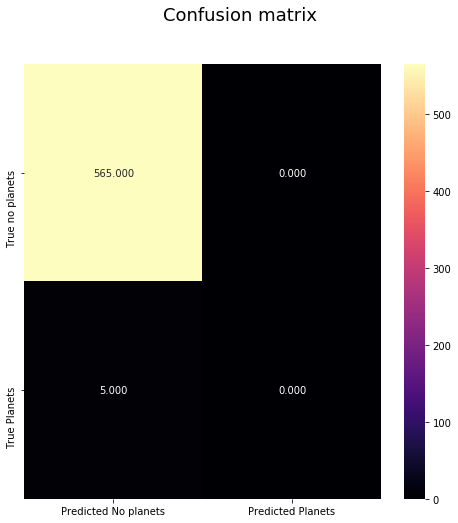

In [87]:
svc = SVC(gamma='auto')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
evaluate_prediction(y_test, y_pred)

## Modeling on Detrended data

In [88]:
# x_train = np.load("data/x_train_detrend.npy")
# x_test = np.load("data/x_test_detrend.npy")

# y_train = np.load("data/label_train.npy")
# y_test = np.load("data/label_test.npy")

x_train = load_csv_Watson('x_train_detrend.csv')
x_test = load_csv_Watson('x_test_detrend.csv')

y_train = load_csv_Watson('labels_train.csv')
y_test = load_csv_Watson('labels_test.csv')

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [89]:
# custom train generators
train_gen = train_generator(x_train, y_train, ratio_of_minor=0.2, batch_size=100)
val_gen = train_generator(x_train, y_train, ratio_of_minor=0.2, batch_size=50)
train_gen_mlp = train_generator(x_train, y_train, ratio_of_minor=0.25, batch_size=100, mlp=True)
val_gen_mlp = train_generator(x_train, y_train, ratio_of_minor=0.25, batch_size=50, mlp=True)
a, b = next(train_gen)
a.shape, b.shape

((100, 3197, 1), (100,))

In [90]:
md_trend = Dense_Net((x_train.shape[1],))

In [91]:
ml_trend = LSTM_Net((x_train.shape[1], 1))

In [92]:
mc_trend = CNN1D((x_train.shape[1], 1))

In [94]:
md_trend.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
md_trend_trainer = Trainer(md_trend, 'md_trend', train_gen_mlp, val_gen_mlp)
md_trend_trainer.train(25, 1)

Train on 100 samples, validate on 49 samples
100/100 [==============================] - 5s 55ms/sample - loss: 0.6212 - acc: 0.7200 - val_loss: 0.5605 - val_acc: 0.7551
val_loss improved from 10000000000.00 to 0.56
Model is saved on epoch 1.
Train on 100 samples, validate on 49 samples
Epoch 2/2
100/100 [==============================] - 7s 68ms/sample - loss: 0.5448 - acc: 0.7600 - val_loss: 0.4505 - val_acc: 0.7755
val_loss improved from 0.56 to 0.45
Model is saved on epoch 2.
Train on 100 samples, validate on 49 samples
Epoch 3/3
100/100 [==============================] - 3s 29ms/sample - loss: 0.4031 - acc: 0.8100 - val_loss: 0.2774 - val_acc: 0.8980
val_loss improved from 0.45 to 0.28
Model is saved on epoch 3.
Train on 100 samples, validate on 49 samples
Epoch 4/4
100/100 [==============================] - 3s 29ms/sample - loss: 0.2793 - acc: 0.8700 - val_loss: 0.1880 - val_acc: 0.9388
val_loss improved from 0.28 to 0.19
Model is saved on epoch 4.
Train on 100 samples, validate o

In [0]:
ml_trend.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
ml_trend_trainer = Trainer(ml_trend, 'ml_trend', train_gen, val_gen)
ml_trend_trainer.train(4, 1)

In [95]:
mc_trend.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
mc_trend_trainer = Trainer(mc_trend, 'mc_trend', train_gen, val_gen)
mc_trend_trainer.train(25, 1)

Train on 100 samples, validate on 50 samples
100/100 [==============================] - 37s 374ms/sample - loss: 0.5622 - acc: 0.7600 - val_loss: 0.4820 - val_acc: 0.8000
val_loss improved from 10000000000.00 to 0.48
Model is saved on epoch 1.
Train on 100 samples, validate on 50 samples
Epoch 2/2
100/100 [==============================] - 40s 399ms/sample - loss: 0.5387 - acc: 0.8000 - val_loss: 0.4833 - val_acc: 0.8000
val_loss did not improve.
Train on 100 samples, validate on 50 samples
Epoch 3/3
100/100 [==============================] - 36s 357ms/sample - loss: 0.5025 - acc: 0.8000 - val_loss: 0.4239 - val_acc: 0.8000
val_loss improved from 0.48 to 0.42
Model is saved on epoch 3.
Train on 100 samples, validate on 50 samples
Epoch 4/4
100/100 [==============================] - 40s 399ms/sample - loss: 0.4084 - acc: 0.8000 - val_loss: 0.3568 - val_acc: 0.8000
val_loss improved from 0.42 to 0.36
Model is saved on epoch 4.
Train on 100 samples, validate on 50 samples
Epoch 5/5
100/10

,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.0,0.985841,0.0,0.991103,0.0


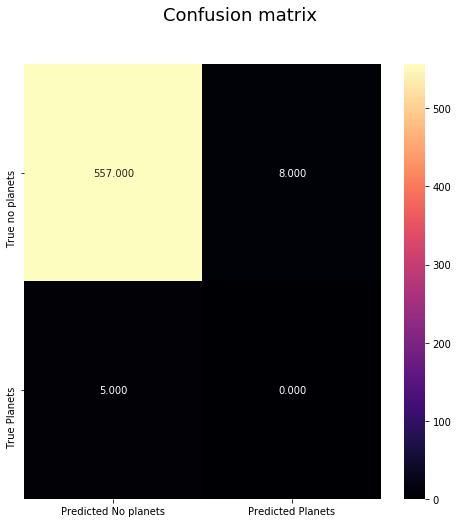

In [96]:
md_trend_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
md_trend = md_trend_trainer.model
y_pred = md_trend.predict(x_test)
evaluate_prediction(y_test, y_pred)

In [0]:
ml_trend_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
ml_trend = ml_trend_trainer.model
y_pred = mc_trend.predict(x_test[:, :, np.newaxis])
evaluate_prediction(y_test, y_pred)

,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.6,0.99292,0.428571,0.996448,0.599359


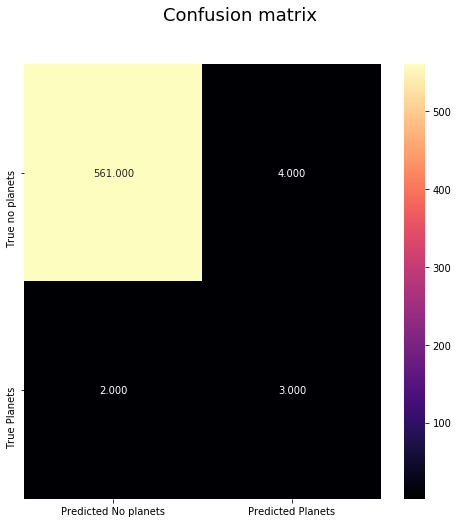

In [98]:
mc_trend_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
mc_trend = mc_trend_trainer.model
y_pred = mc_trend.predict(x_test[:, :, np.newaxis])
evaluate_prediction(y_test, y_pred)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.0,1.0,0,0.991228,0.0


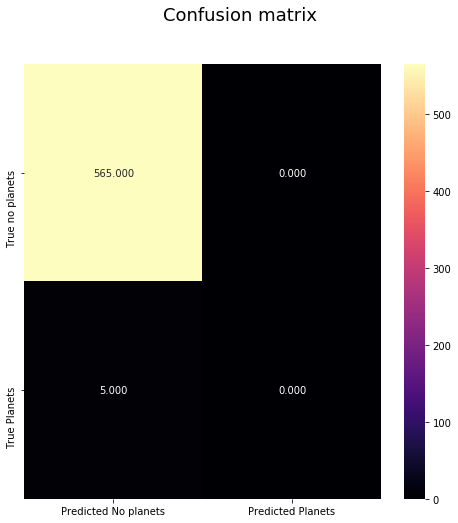

In [99]:
svc = SVC(gamma='auto')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
evaluate_prediction(y_test, y_pred)

## Modeling on Frequency Data

In [15]:
# x_train = np.load("data/x_train_freq.npy")
# x_test = np.load("data/x_test_freq.npy")

# y_train = np.load("data/label_train.npy")
# y_test = np.load("data/label_test.npy")

x_train = load_csv_Watson('x_train_freq.csv')
x_test = load_csv_Watson('x_test_freq.csv')

y_train = load_csv_Watson('labels_train.csv')
y_test = load_csv_Watson('labels_test.csv')

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
# custom train generators
train_gen = train_generator(x_train, y_train, ratio_of_minor=0.2, batch_size=100)
val_gen = train_generator(x_train, y_train, ratio_of_minor=0.2, batch_size=50)
train_gen_mlp = train_generator(x_train, y_train, ratio_of_minor=0.25, batch_size=100, mlp=True)
val_gen_mlp = train_generator(x_train, y_train, ratio_of_minor=0.25, batch_size=50, mlp=True)
a, b = next(train_gen)
a.shape, b.shape

((100, 1598, 1), (100,))

In [18]:
md_freq = Dense_Net((x_train.shape[1], ))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
ml_freq = LSTM_Net((x_train.shape[1], 1))

In [20]:
mc_freq = CNN1D((x_train.shape[1], 1))

In [21]:
md_freq.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
md_freq_trainer = Trainer(md_freq, 'md_freq', train_gen_mlp, val_gen_mlp)
md_freq_trainer.train(25, 1)

Instructions for updating:
Use tf.cast instead.
Train on 100 samples, validate on 49 samples
Instructions for updating:
Use tf.cast instead.
100/100 [==============================] - 11s 113ms/sample - loss: 1.6907 - acc: 0.5700 - val_loss: 0.8522 - val_acc: 0.7143
val_loss improved from 10000000000.00 to 0.85
Model is saved on epoch 1.
Train on 100 samples, validate on 49 samples
Epoch 2/2
100/100 [==============================] - 3s 28ms/sample - loss: 1.4174 - acc: 0.6500 - val_loss: 0.3718 - val_acc: 0.8980
val_loss improved from 0.85 to 0.37
Model is saved on epoch 2.
Train on 100 samples, validate on 49 samples
Epoch 3/3
100/100 [==============================] - 3s 26ms/sample - loss: 0.4962 - acc: 0.8500 - val_loss: 0.4486 - val_acc: 0.8776
val_loss did not improve.
Train on 100 samples, validate on 49 samples
Epoch 4/4
100/100 [==============================] - 8s 79ms/sample - loss: 0.4132 - acc: 0.8600 - val_loss: 0.4786 - val_acc: 0.9184
val_loss did not improve.
Train on

In [22]:
ml_freq.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
ml_freq_trainer = Trainer(ml_freq, 'ml_freq', train_gen, val_gen)
ml_freq_trainer.train(1, 1)

Train on 100 samples, validate on 50 samples
100/100 [==============================] - 2837s 28s/sample - loss: 0.5294 - acc: 0.7800 - val_loss: 0.5268 - val_acc: 0.8000
val_loss improved from 10000000000.00 to 0.53
Model is saved on epoch 1.
Model is loaded from a disk


In [23]:
mc_freq.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
mc_freq_trainer = Trainer(mc_freq, 'mc_freq', train_gen, val_gen)
mc_freq_trainer.train(15, 1)

Train on 100 samples, validate on 50 samples
100/100 [==============================] - 30s 302ms/sample - loss: 2.6351 - acc: 0.7600 - val_loss: 1.5960 - val_acc: 0.8000
val_loss improved from 10000000000.00 to 1.60
Model is saved on epoch 1.
Train on 100 samples, validate on 50 samples
Epoch 2/2
100/100 [==============================] - 34s 336ms/sample - loss: 1.0866 - acc: 0.7800 - val_loss: 0.4897 - val_acc: 0.8000
val_loss improved from 1.60 to 0.49
Model is saved on epoch 2.
Train on 100 samples, validate on 50 samples
Epoch 3/3
100/100 [==============================] - 28s 285ms/sample - loss: 0.5039 - acc: 0.8300 - val_loss: 0.4995 - val_acc: 0.8800
val_loss did not improve.
Train on 100 samples, validate on 50 samples
Epoch 4/4
100/100 [==============================] - 30s 303ms/sample - loss: 0.4441 - acc: 0.8300 - val_loss: 0.5129 - val_acc: 0.8400
val_loss did not improve.
Train on 100 samples, validate on 50 samples
Epoch 5/5
100/100 [==============================] - 

,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.0,1.0,0,0.991228,0.0


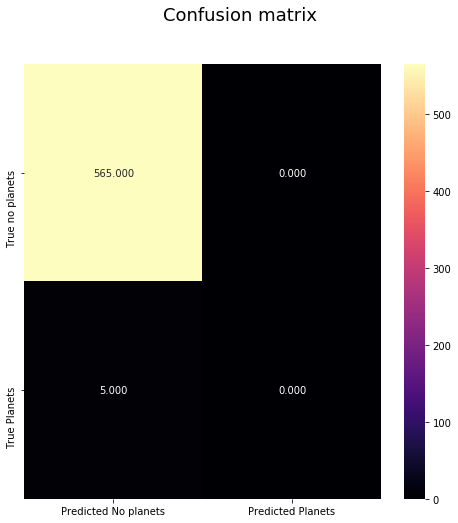

In [24]:
md_freq_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
md_freq = md_freq_trainer.model
y_pred = md_freq.predict(x_test)
evaluate_prediction(y_test, y_pred)

,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.0,1.0,0,0.991228,0.0


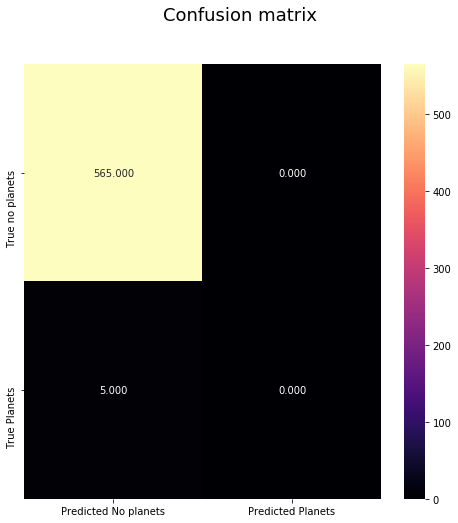

In [25]:
ml_freq_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
ml_freq = ml_freq_trainer.model
y_pred = ml_freq.predict(x_test[:, :, np.newaxis])
evaluate_prediction(y_test, y_pred)

,Sensitivity,Specificity,Precision,Recall,F1-score
0,1.0,0.985841,0.384615,1.0,0.555556


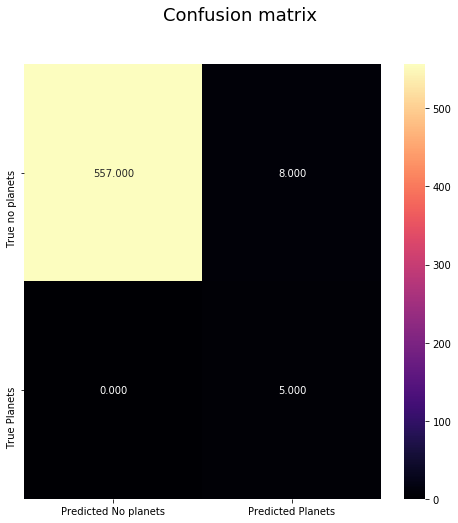

In [26]:
mc_freq_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
mc_freq = mc_freq_trainer.model
y_pred = mc_freq.predict(x_test[:, :, np.newaxis])
evaluate_prediction(y_test, y_pred)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.0,1.0,0,0.991228,0.0


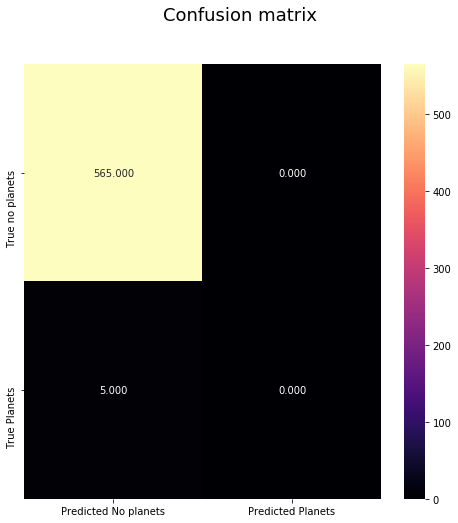

In [27]:
svc = SVC(gamma='auto')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
evaluate_prediction(y_test, y_pred)

### Conclusion

Multiple approaches to solve the given problem were tried and tested in the current notebook. A set of utility functions was introduced to facilitate the training and comparison. Due to the extreme skew toward planetless instances, models struggled to learn features necessary to identify the ones with exoplanets in their orbits. Thus, a custom data generator, that allows to boost an amount of instances of a given class in a batch, was created to compensate. That also renders `'accuracy'` metric useless, as just predicting 0 all the time already approaches its value to 0.99.

On the other hand, a more reliable set of evaluation measures is computed in the function dedicated to the evaluation of prediction.
It may have been observed, that the convolutional network was the most efficient model in every experiment: it has the highest performance on the test set, its training is fast enough and there's surely room to improve. LSTM-based network appears to be terribly slow in training, which makes it harder to optimize, however, it may also be a possible ***good*** model.

***Nonetheless, one chooses to proceed with convolutional network as the final model.***

Finally, every data augmentation that was introduced has borne its fruit. A wavelet augmentation, however, prooved to be very slow and inefficient, moreover, not universal approach. ***Detrended and frequency data both give a significant improvement but its hard to decide which one is the best, so probably both should be investigated further.***